In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports
#the problem is too simple to be run on GPU. Seriously.
%env THEANO_FLAGS='device=cpu'
import theano
import theano.tensor as T
floatX = theano.config.floatX

import lasagne


env: THEANO_FLAGS='device=cpu'


/usr/local/lib/python2.7/dist-packages/Theano-0.8.0rc1-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
%load_ext autoreload
%autoreload 2

# This tutorial explains the basic pipline of Agentnet experiment
* experiment setup
* designing agent
* interacting with environment
* computing losses
* training

# Experiment setup
* Here we load a simple experiment environment (description below)
* Designing one from scratch is explained in later tutorials

In [3]:
import agentnet.experiments.boolean_reasoning as experiment
print experiment.__doc__


This is a dummy experiment setup that requires agent to make advantage of
a simple logical formula in order to maximize expected reward.

The world agent exists in has a number of boolean hidden factors:
X1~3, Y1, Y2.

The factors are not independent. Namely,
 - Y1 = (not X1) and X2
 - Y2 = not Y1

In the initial moment of time, agent knows nothing about any of them.
At each turn, agent may decide to
 - "open" one of the hidden factors.
   - if the factor turns out to be 1, agent receives +1 reward for X*, +3 for Y*
   - Otherwise, the reward equals -1 for X*, -3 for Y*
   - checking a single factor more than once a session will result in -0.5 reward for every attempt but for first one
 - decide to quit session
   - yields reward of 0 and ends the interaction.
   - all farther actions will have no effect until next session

It is expected, that in order to maximize it's expected reward, the agent
will converge to a strategy of polling X for as long as they yield information
on Y, and 

In [4]:
#Create an environment with all default parameters
env = experiment.BooleanReasoningEnvironment()

# agent setup
* An agent implementation has to contain three parts:
 * Memory layer(s)
  * in this case, a single one-step GRU
 * Q-values evaluation layers
  * in this case, a lasagne dense layer based on memory layer
 * Resolver - acton picker layer
  * in this case, the resolver has epsilon-greedy policy

In [5]:
from agentnet.resolver import EpsilonGreedyResolver
from agentnet.memory import GRUMemoryLayer
from agentnet.agent import Agent

In [6]:
import lasagne

#only 10 hidden neurons
n_hid=10


_observation_layer = lasagne.layers.InputLayer([None,env.observation_size],name="obs_input")
_prev_state_layer = lasagne.layers.InputLayer([None,n_hid],name="prev_state_input")

#memory
#note that this isn't the same as lasagne recurrent units (see next text tab for detail)
gru = GRUMemoryLayer(n_hid,
                     _observation_layer,
                     _prev_state_layer,
                     name="gru0")

#q_eval
q_eval = lasagne.layers.DenseLayer(gru,num_units = env.n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,name="QEvaluator")

#resolver
epsilon = theano.shared(np.float32(0.1),name="e-greedy.epsilon")

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")


#all together
agent = Agent(_observation_layer,
              {gru:_prev_state_layer},
              q_eval,resolver)


In [7]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[gru0.W_in_to_updategate,
 gru0.W_hid_to_updategate,
 gru0.b_updategate,
 gru0.W_in_to_resetgate,
 gru0.W_hid_to_resetgate,
 gru0.b_resetgate,
 gru0.W_in_to_hidden_update,
 gru0.W_hid_to_hidden_update,
 gru0.b_hidden_update,
 QEvaluator.W,
 QEvaluator.b]

## Agent setup in detail
* __Memory layers__
 * One-step recurrent layer
     * takes input and one's previous state
     * returns new memory state
   * Can be arbitrary lasagne layer
   * Several one-step recurrent units are implemented in __agentnet.memory__
   * Note that lasagne's default recurrent networks roll for several steps at once
     * in other words, __using lasagne recurrent units as memory means recurrence inside recurrence__
 * Using more than one memory layer is explained in farther tutorials


* __Q-values evaluation layer__
 * Can be arbitrary lasagne network
 * returns predicted Q-values for each action
 * Usually depends on memory as an input


* __Resolver__ - action picker
 * Decides on what action is taken
 * Normally takes Q-values as input
 * Currently all experiments require integer output
 * Several resolver layers are implemented in __agentnet.resolver__

# Interacting with environment
* an agent has a method that produces symbolic environment interaction sessions
* Such sessions are represented as tensors with dimensions matching pattern [batch_session_i, time_tick, ...]
* interactions result in sequences of observations, actions, q-values,etc
* one has to pre-define maximum session length.
 * in this case, environment implements an indicator of whether session has ended by current tick
* Since this environment also implements Objective methods, it can evaluate rewards for each [batch, time_tick]


In [8]:
#produce interaction sequences of length <= 10
env_states,observations,agent_state,actions,tracked = agent.get_sessions(
    env,
    session_length=10,
    batch_size=env.batch_size,
)



state_seq = env_states[0]
observation_seq = observations[0]
hidden_seq = agent_state[0]
action_seq = actions[0]
qvalues_seq = tracked[0]

#get rewards for all actions
rewards_seq = env.get_reward_sequences(env_states,actions)

#get indicator whether session is still active
is_alive_seq = env.get_whether_alive(observations)


/home/jheuristic/Documents/AgentNet/agentnet/utils/format.py:15: UserWarning: Elemwise{switch,no_inplace}.0 will be treated as a single input/output tensor, and not a collection of such.If you want otherwise, please cast it to list/tuple
  warn(str(variables)+ " will be treated as a single input/output tensor, and not a collection of such."\
/home/jheuristic/Documents/AgentNet/agentnet/utils/format.py:15: UserWarning: Join.0 will be treated as a single input/output tensor, and not a collection of such.If you want otherwise, please cast it to list/tuple
  warn(str(variables)+ " will be treated as a single input/output tensor, and not a collection of such."\


# Evaluating loss function
* In this case, we want to 
 * first get pairs of (predicted Qvalue, reference Qvalue) for all actions commited
 * second, define loss function
 * third, compute grad and update weights

#### Define loss functions

In [9]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import qlearning


#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = theano.shared(np.float32(0.95),name = 'q_learning_gamma')


squarred_Qerror = qlearning.get_elementwise_objective(
    qvalues_seq,
    action_seq,
    rewards_seq,
    is_alive_seq,
    gamma_or_gammas=gamma,)


mse_Qloss = squarred_Qerror.sum(axis = 1).mean()

In [10]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-3

In [11]:
loss = mse_Qloss + reg_l2

#### Compute weight updates

In [12]:
updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.1)

#### Some auxilary evaluation metrics

In [13]:
mean_session_reward = rewards_seq.sum(axis=1).mean()
#...

# Compile train and evaluation functions

In [14]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)

evaluation_fun = theano.function([],[loss,mse_Qloss,reg_l2,mean_session_reward])

# session visualization tools


* this is a completely optional step of visualizing agent's sessions as chains of actions
* usually useful to get insight on what worked and what din't
* in this case, we print strings following pattern
  * [action_name] ([predicted action qvalue]) -> reward [reference qvalue] | next iteration

* plot shows
    * time ticks over X, abstract values over Y
    * bold lines are Qvalues for actions
    * dots on bold lines represent what actions were taken at each moment of time
    * dashed lines are agent's hidden state neurons
    * blue vertical line - session end
    
    
__Warning! the visualization tools are underdeveloped and only allow simple operations.__

if you found yourself struggling to make it do what you want for 5 minutes, go write your own tool [and contribute it :)]


In [15]:
from agentnet.display.sessions import print_sessions
get_printables = theano.function([], [
        hidden_seq,qvalues_seq, action_seq,rewards_seq,is_alive_seq
    ])

def display_sessions(with_plots = False):
        
    hidden_log,qvalues_log,actions_log,reward_log, is_alive_log = get_printables()
    
    
    print_sessions(qvalues_log,actions_log,reward_log,
                   is_alive_seq = is_alive_log,
                   hidden_seq=hidden_log,
                   action_names=env.feature_names,
                  
                  plot_policy = with_plots)

session # 0
 X1(qv = 0.0) -> -1.0 |  Y1(qv = 0.107300142626) -> -3.0 | 



/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


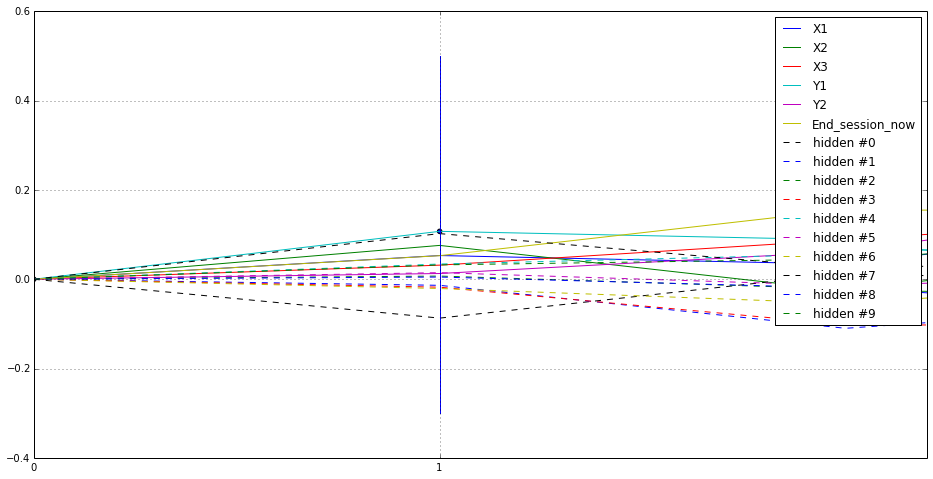

In [16]:
#visualize untrained network performance (which is mostly random)
env.generate_new_data_batch(1)
display_sessions(with_plots=True)

# Training loop

In [17]:
from agentnet.display import Metrics
score_log = Metrics()

In [18]:
#starting epoch
epoch_counter = 1

#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

epoch 100,loss 8.58748, epsilon 0.96275, rewards: ( e-greedy -0.19500, greedy -0.27000) 
rec 8.574 reg 0.014
epoch 200,loss 12.14298, epsilon 0.92696, rewards: ( e-greedy -0.28550, greedy -0.57300) 
rec 12.129 reg 0.014
epoch 300,loss 8.31565, epsilon 0.89257, rewards: ( e-greedy -0.38195, greedy -0.90570) 
rec 8.302 reg 0.014
epoch 400,loss 13.87725, epsilon 0.85954, rewards: ( e-greedy -0.37876, greedy -1.02513) 
rec 13.863 reg 0.014
epoch 500,loss 8.49647, epsilon 0.82779, rewards: ( e-greedy -0.37588, greedy -1.24762) 
rec 8.482 reg 0.014
epoch 600,loss 9.56589, epsilon 0.79730, rewards: ( e-greedy -0.31829, greedy -1.37286) 
rec 9.551 reg 0.015
epoch 700,loss 13.70898, epsilon 0.76799, rewards: ( e-greedy -0.33646, greedy -1.55557) 
rec 13.693 reg 0.016
epoch 800,loss 9.33301, epsilon 0.73984, rewards: ( e-greedy -0.28782, greedy -1.37501) 
rec 9.316 reg 0.017
epoch 900,loss 7.61453, epsilon 0.71279, rewards: ( e-greedy -0.25403, greedy -1.07751) 
rec 7.596 reg 0.018
epoch 1000,lo

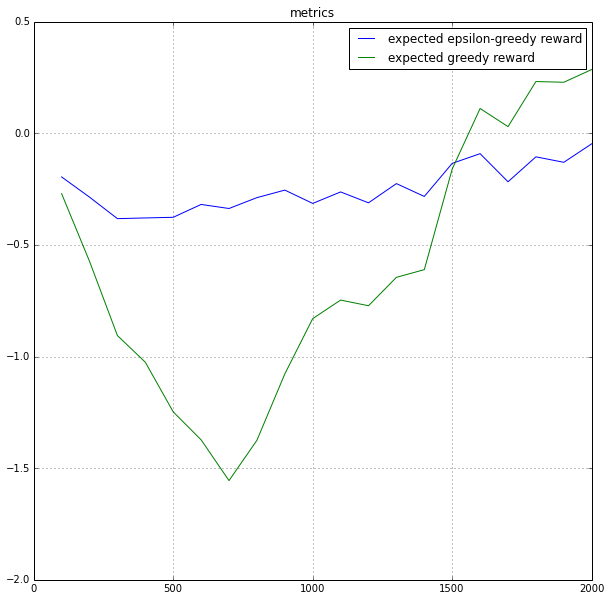

Random session examples
session # 0
 Y2(qv = 1.16340126842) -> -3.0 |  X2(qv = 0.171740545596) -> 1.0 |  Y2(qv = 0.141066972298) -> -0.5 | 



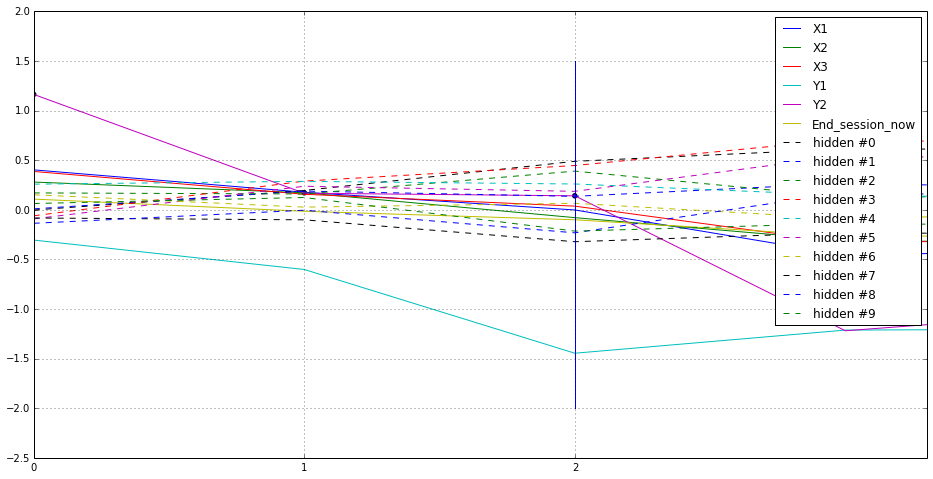

session # 1
 X1(qv = 0.402558732253) -> 1.0 |  X2(qv = 0.22850829194) -> 1.0 |  Y2(qv = 0.463630629427) -> 3.0 | 



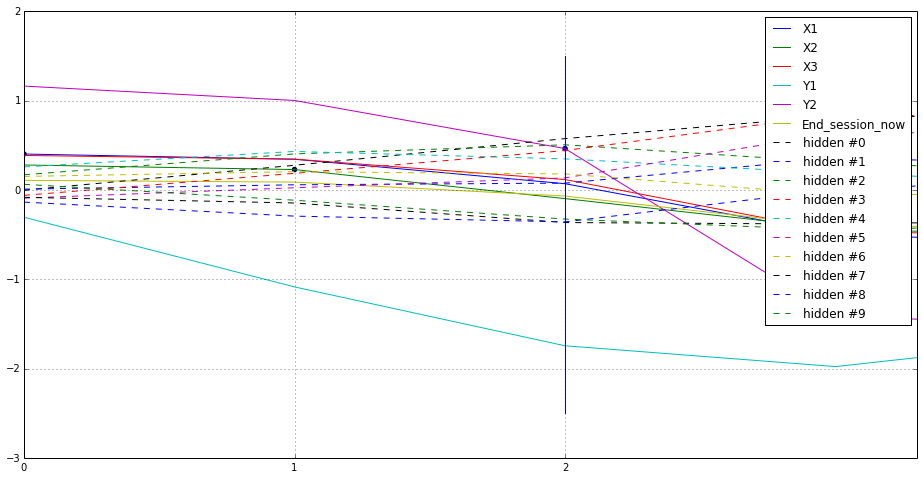

session # 2
 X3(qv = 0.386614783619) -> 1.0 |  X2(qv = 0.0931969065382) -> -1.0 |  Y2(qv = 0.957872512662) -> 3.0 | 



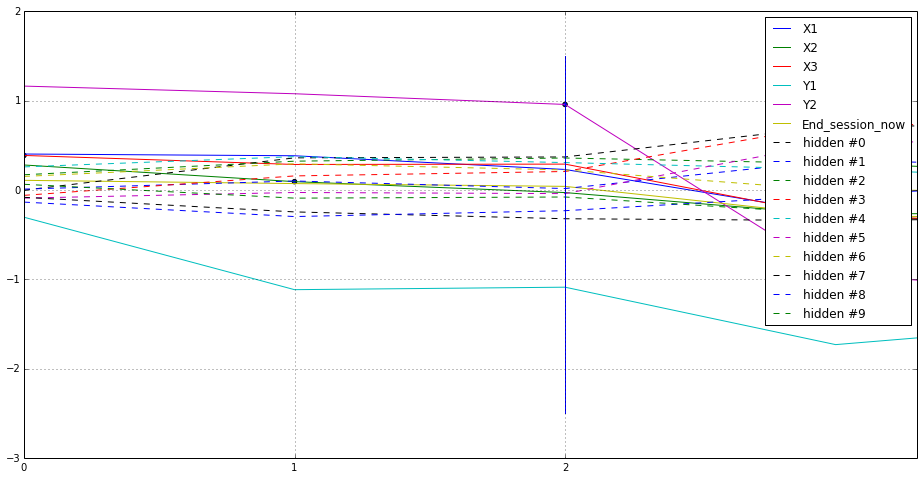

epoch 2100,loss 10.78113, epsilon 0.46012, rewards: ( e-greedy 0.02308, greedy 0.41260) 
rec 10.752 reg 0.029
epoch 2200,loss 13.87802, epsilon 0.44404, rewards: ( e-greedy -0.14923, greedy 0.29634) 
rec 13.848 reg 0.030
epoch 2300,loss 10.73866, epsilon 0.42859, rewards: ( e-greedy -0.13430, greedy 0.32671) 
rec 10.708 reg 0.030
epoch 2400,loss 8.68211, epsilon 0.41375, rewards: ( e-greedy 0.00913, greedy 0.46904) 
rec 8.651 reg 0.031
epoch 2500,loss 6.14032, epsilon 0.39949, rewards: ( e-greedy 0.06821, greedy 0.62213) 
rec 6.109 reg 0.031
epoch 2600,loss 9.51690, epsilon 0.38578, rewards: ( e-greedy 0.12139, greedy 0.63492) 
rec 9.485 reg 0.032
epoch 2700,loss 10.00889, epsilon 0.37262, rewards: ( e-greedy 0.19925, greedy 0.67643) 
rec 9.977 reg 0.032
epoch 2800,loss 7.21054, epsilon 0.35997, rewards: ( e-greedy 0.27433, greedy 0.86878) 
rec 7.178 reg 0.033
epoch 2900,loss 5.42936, epsilon 0.34781, rewards: ( e-greedy 0.47190, greedy 1.10191) 
rec 5.396 reg 0.033
epoch 3000,loss 8.6

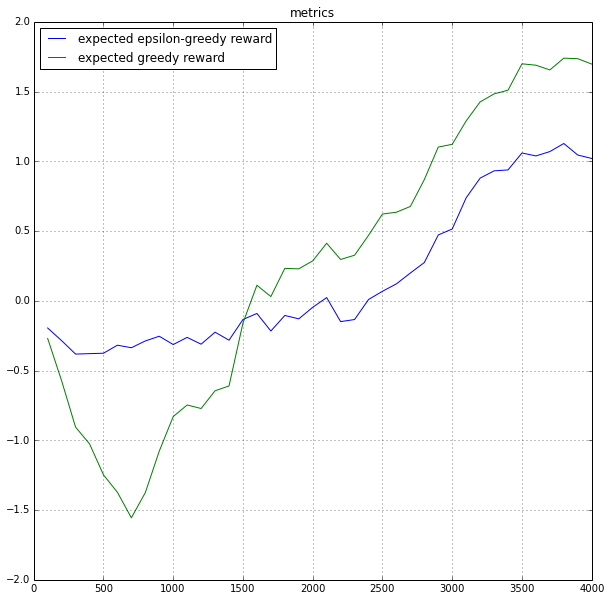

Random session examples
session # 0
 Y2(qv = 1.75682487147) -> 3.0 |  X1(qv = 0.222232033475) -> 1.0 | 



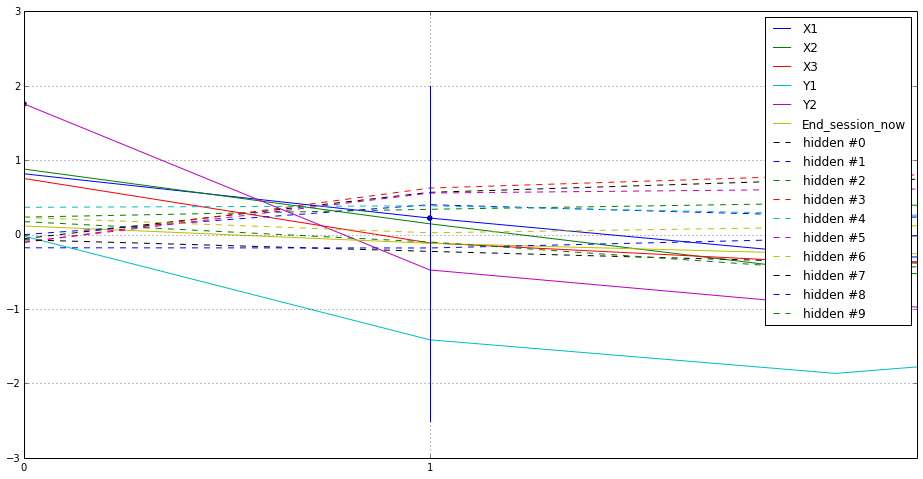

session # 1
 X1(qv = 0.817428029359) -> -1.0 |  Y2(qv = 2.12161101645) -> 3.0 |  X1(qv = 0.143367570188) -> -0.5 | 



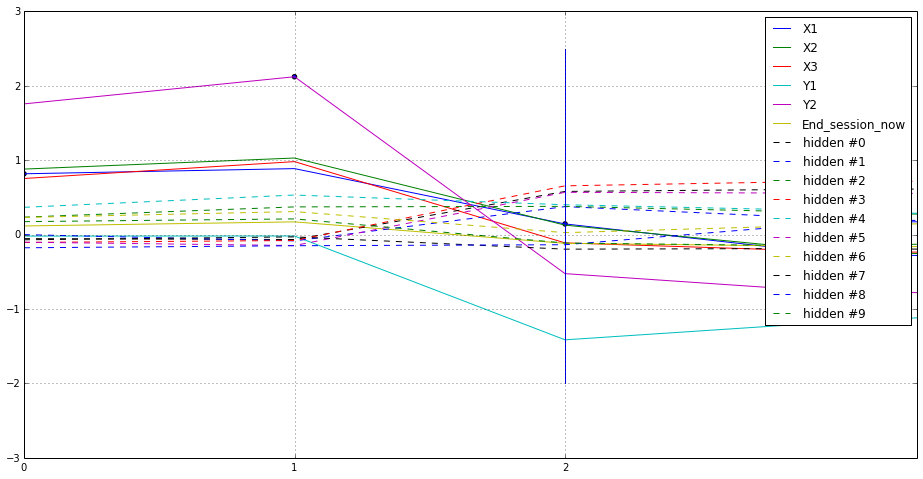

session # 2
 Y2(qv = 1.75682487147) -> -3.0 |  X2(qv = 0.791149658506) -> 1.0 |  X3(qv = -0.0662755199295) -> -1.0 |  X3(qv = -0.0858616381797) -> -0.5 | 



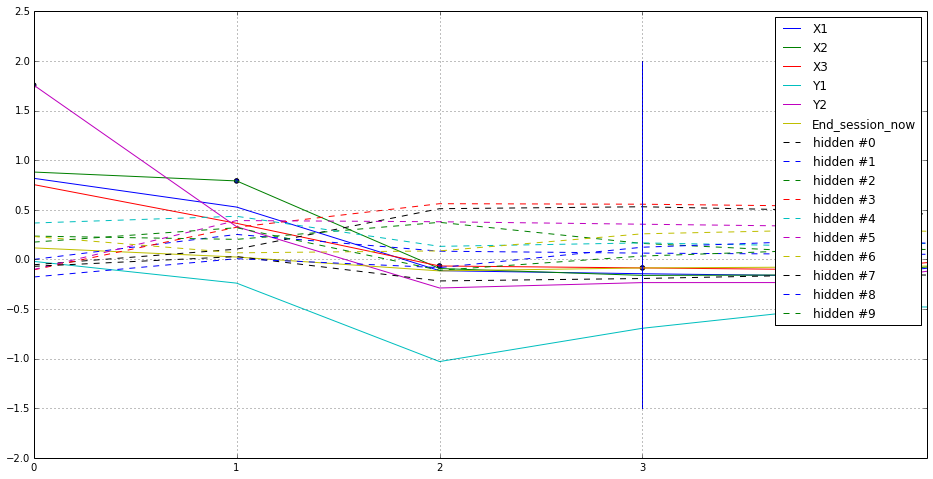

epoch 4100,loss 11.49071, epsilon 0.23428, rewards: ( e-greedy 1.08341, greedy 1.69229) 
rec 11.452 reg 0.039
epoch 4200,loss 4.67479, epsilon 0.22706, rewards: ( e-greedy 1.19007, greedy 1.75306) 
rec 4.636 reg 0.039
epoch 4300,loss 6.26640, epsilon 0.22011, rewards: ( e-greedy 1.11106, greedy 1.83275) 
rec 6.227 reg 0.039
epoch 4400,loss 4.97055, epsilon 0.21344, rewards: ( e-greedy 1.23995, greedy 1.89948) 
rec 4.931 reg 0.040
epoch 4500,loss 10.08496, epsilon 0.20703, rewards: ( e-greedy 1.24596, greedy 1.86453) 
rec 10.045 reg 0.040
epoch 4600,loss 3.49967, epsilon 0.20088, rewards: ( e-greedy 1.42136, greedy 2.01808) 
rec 3.459 reg 0.040
epoch 4700,loss 8.14264, epsilon 0.19496, rewards: ( e-greedy 1.42423, greedy 1.97627) 
rec 8.102 reg 0.041
epoch 4800,loss 6.25480, epsilon 0.18928, rewards: ( e-greedy 1.43180, greedy 1.98364) 
rec 6.214 reg 0.041
epoch 4900,loss 8.12597, epsilon 0.18382, rewards: ( e-greedy 1.40862, greedy 1.97528) 
rec 8.085 reg 0.041
epoch 5000,loss 4.47496,

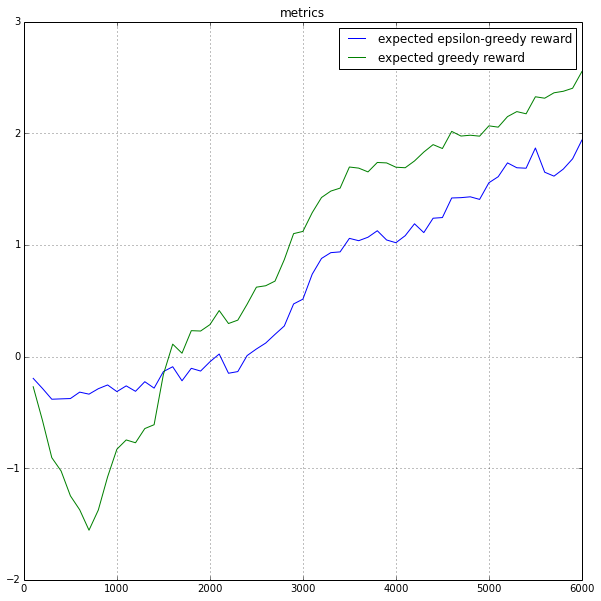

Random session examples
session # 0
 Y2(qv = 1.96594786613) -> 3.0 |  X1(qv = 0.292246598438) -> 1.0 |  X3(qv = -0.0652372011447) -> -1.0 | 



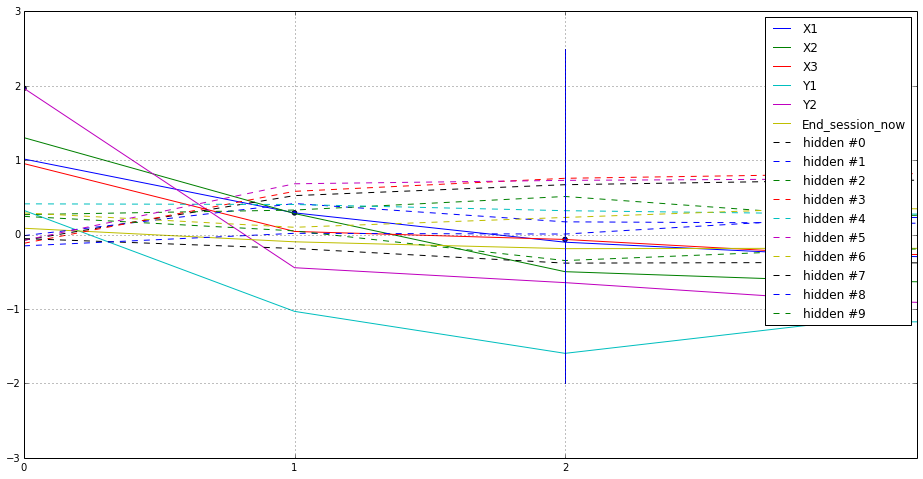

session # 1
 Y2(qv = 1.96594786613) -> -3.0 |  X2(qv = 1.57887288506) -> 1.0 |  Y1(qv = 1.44141381391) -> 3.0 |  X3(qv = 0.0328697474267) -> -1.0 |  X3(qv = -0.00861144203162) -> -0.5 |  Y1(qv = 0.0844292488788) -> -0.5 | 



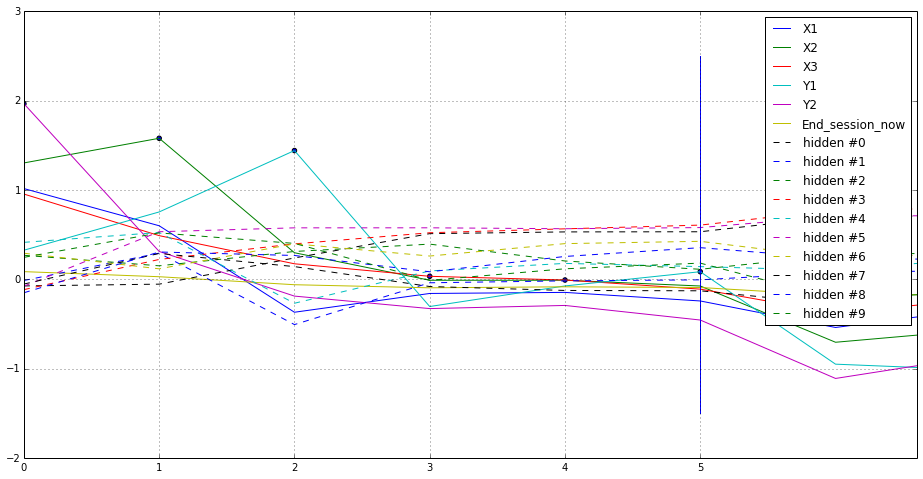

session # 2
 X2(qv = 1.30273525465) -> 1.0 |  Y2(qv = 1.35978447241) -> -3.0 |  X2(qv = 0.889510904603) -> -0.5 |  X1(qv = -0.715780838291) -> -1.0 |  Y1(qv = 0.268232879519) -> 3.0 | 



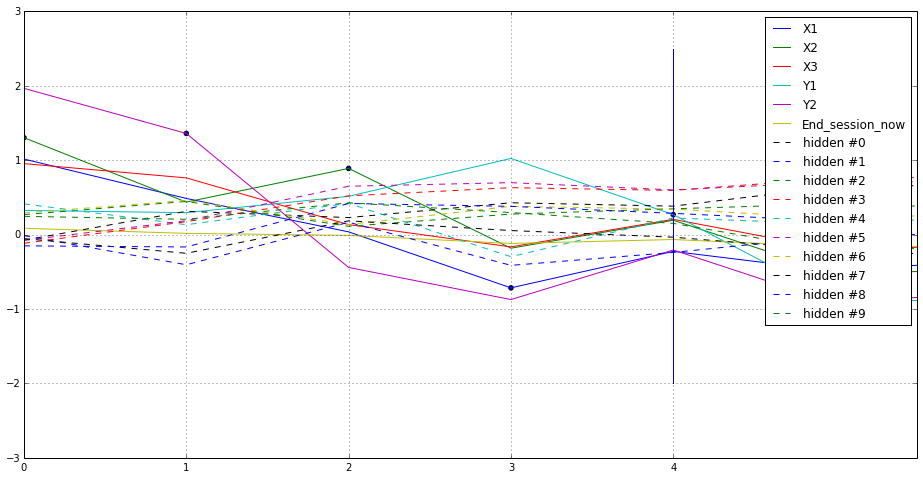

epoch 6100,loss 4.77000, epsilon 0.13280, rewards: ( e-greedy 1.99607, greedy 2.65883) 
rec 4.708 reg 0.062
epoch 6200,loss 8.96942, epsilon 0.12956, rewards: ( e-greedy 1.92646, greedy 2.56295) 
rec 8.905 reg 0.064
epoch 6300,loss 4.82822, epsilon 0.12644, rewards: ( e-greedy 2.04881, greedy 2.65665) 
rec 4.761 reg 0.067
epoch 6400,loss 4.90813, epsilon 0.12344, rewards: ( e-greedy 2.06393, greedy 2.68599) 
rec 4.840 reg 0.069
epoch 6500,loss 5.01987, epsilon 0.12056, rewards: ( e-greedy 2.11254, greedy 2.70239) 
rec 4.950 reg 0.070
epoch 6600,loss 4.25078, epsilon 0.11779, rewards: ( e-greedy 2.19129, greedy 2.72715) 
rec 4.179 reg 0.072
epoch 6700,loss 5.94994, epsilon 0.11513, rewards: ( e-greedy 2.10716, greedy 2.65943) 
rec 5.876 reg 0.074
epoch 6800,loss 5.78287, epsilon 0.11258, rewards: ( e-greedy 2.03144, greedy 2.57349) 
rec 5.708 reg 0.075
epoch 6900,loss 2.98805, epsilon 0.11013, rewards: ( e-greedy 2.10330, greedy 2.63614) 
rec 2.912 reg 0.076
epoch 7000,loss 3.53960, eps

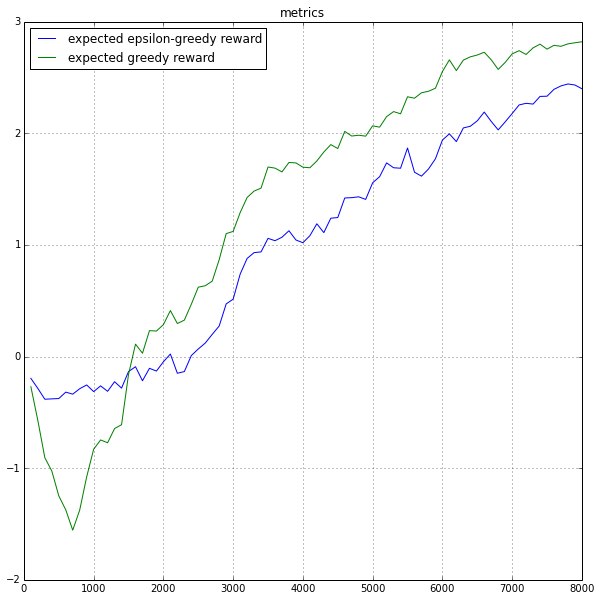

Random session examples
session # 0
 Y1(qv = 0.453204956755) -> -3.0 |  Y2(qv = 2.79641174825) -> 3.0 |  X2(qv = 0.249793079744) -> 1.0 |  X3(qv = -0.13557496268) -> 1.0 | 



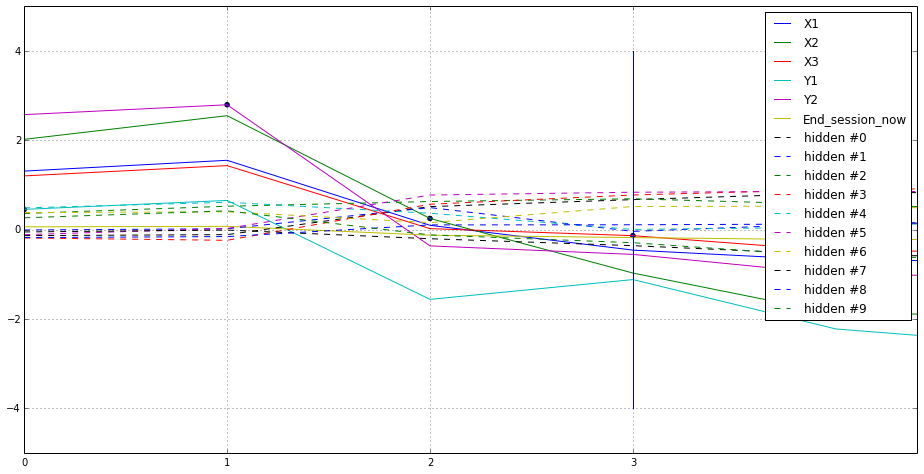

session # 1
 Y2(qv = 2.57515982141) -> -3.0 |  X2(qv = 3.65188605182) -> 1.0 |  Y1(qv = 2.9586677096) -> 3.0 |  X1(qv = -0.521904600534) -> -1.0 |  X3(qv = -0.0715668526001) -> -1.0 | 



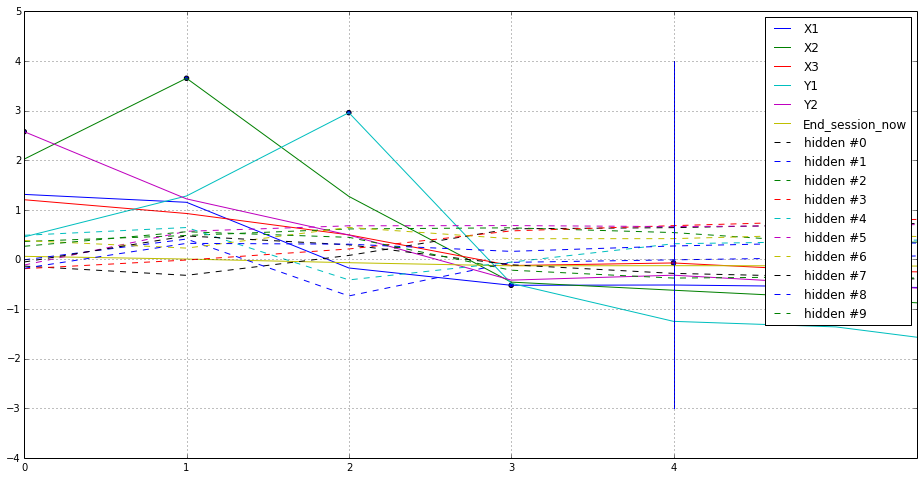

session # 2
 Y2(qv = 2.57515982141) -> 3.0 |  X1(qv = 0.297653708322) -> -1.0 |  X3(qv = 0.0115990160305) -> 1.0 | 



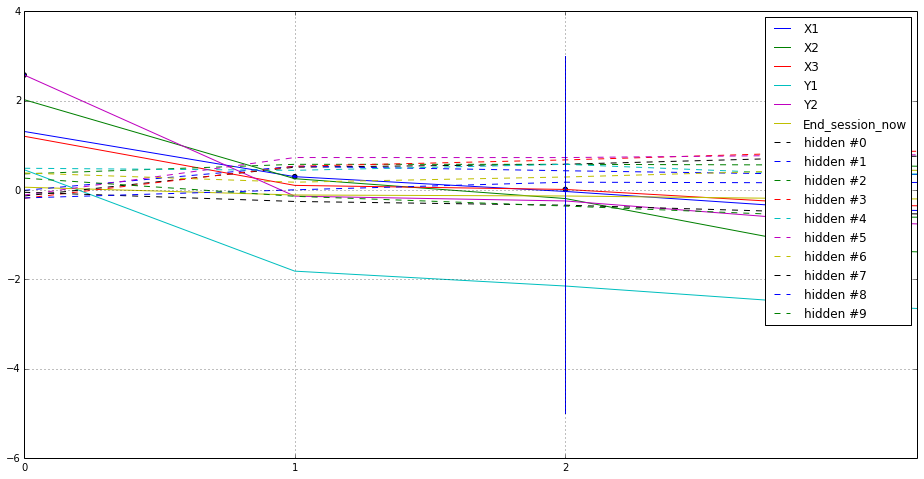

epoch 8100,loss 5.27529, epsilon 0.08721, rewards: ( e-greedy 2.34523, greedy 2.74882) 
rec 5.193 reg 0.082
epoch 8200,loss 3.53934, epsilon 0.08575, rewards: ( e-greedy 2.36071, greedy 2.73394) 
rec 3.458 reg 0.082
epoch 8300,loss 3.12223, epsilon 0.08435, rewards: ( e-greedy 2.39464, greedy 2.75054) 
rec 3.040 reg 0.082
epoch 8400,loss 3.69768, epsilon 0.08300, rewards: ( e-greedy 2.33017, greedy 2.67549) 
rec 3.615 reg 0.082
epoch 8500,loss 3.75769, epsilon 0.08170, rewards: ( e-greedy 2.37716, greedy 2.70794) 
rec 3.675 reg 0.082
epoch 8600,loss 2.59598, epsilon 0.08046, rewards: ( e-greedy 2.47944, greedy 2.78715) 
rec 2.514 reg 0.082
epoch 8700,loss 3.82833, epsilon 0.07927, rewards: ( e-greedy 2.41650, greedy 2.72843) 
rec 3.746 reg 0.082
epoch 8800,loss 2.23207, epsilon 0.07812, rewards: ( e-greedy 2.46485, greedy 2.76559) 
rec 2.150 reg 0.082
epoch 8900,loss 3.70079, epsilon 0.07702, rewards: ( e-greedy 2.38836, greedy 2.73903) 
rec 3.618 reg 0.083
epoch 9000,loss 4.76144, eps

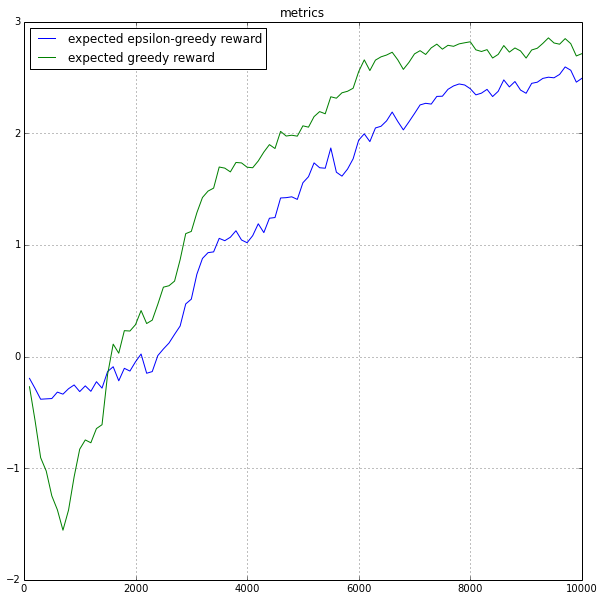

Random session examples
session # 0
 Y2(qv = 2.600437032) -> 3.0 |  X1(qv = 0.337158687579) -> 1.0 |  X3(qv = -0.0116605008581) -> -1.0 | 



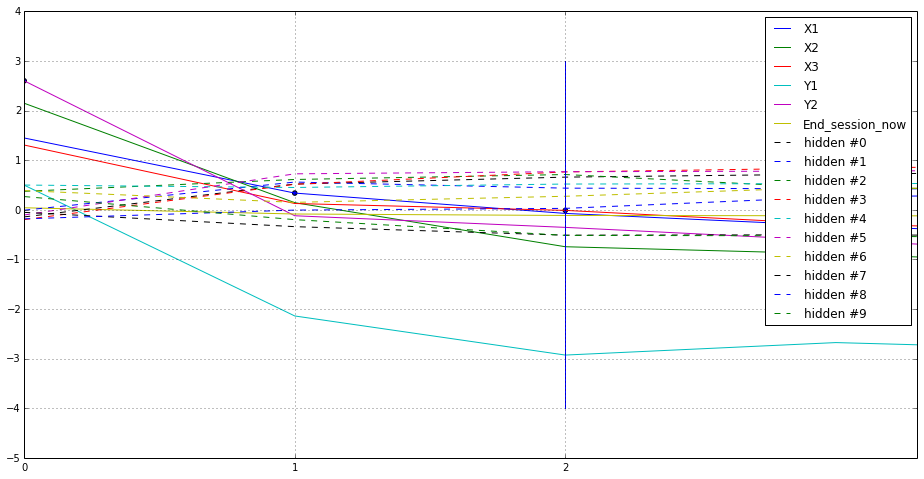

session # 1
 Y2(qv = 2.600437032) -> -3.0 |  X2(qv = 3.80423118085) -> 1.0 |  Y1(qv = 3.02515165212) -> 3.0 |  X3(qv = -0.00292832770056) -> -1.0 | 



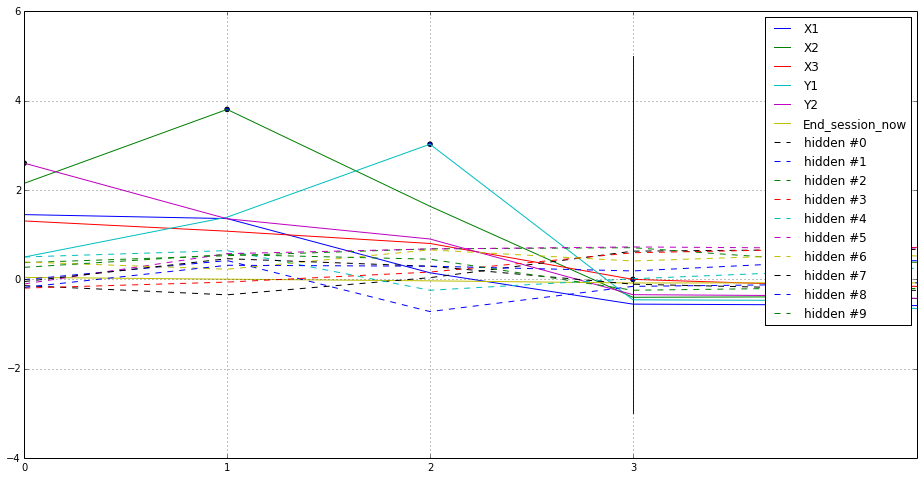

session # 2
 Y2(qv = 2.600437032) -> 3.0 |  X1(qv = 0.337158687579) -> 1.0 |  X3(qv = -0.0116605008581) -> 1.0 | 



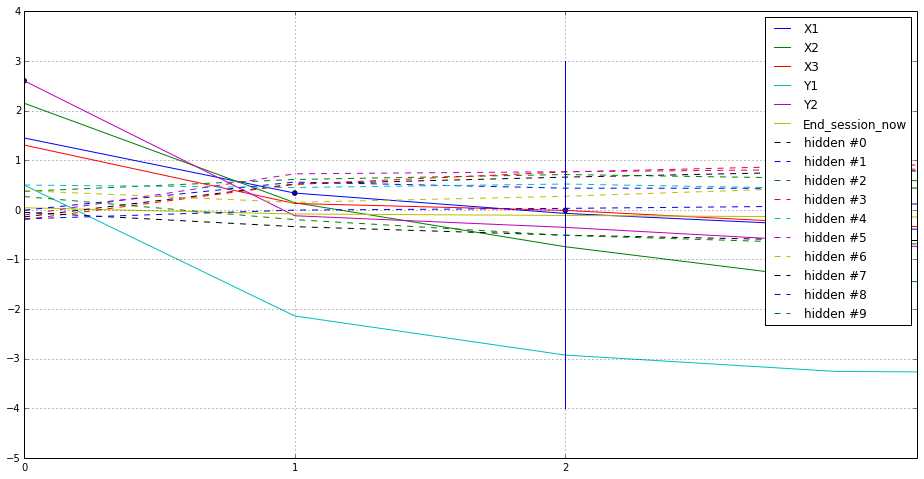

In [19]:
n_epochs = 10000
batch_size=10

for i in range(n_epochs):    
    
    #train
    env.generate_new_data_batch(batch_size)
    loss,avg_reward = train_fun()
    
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%10 ==0:
        current_epsilon =  0.05 + 0.95*np.exp(-epoch_counter/2500.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##show current learning progress
    if epoch_counter%100 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected epsilon-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))

        print "epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,l2_penalty)

        
    #visualize learning curve and sample sessions
    if epoch_counter %2000 ==0:
        print "Learning curves:"
        score_log.plot()
        
        print "Random session examples"
        env.generate_new_data_batch(3)
        display_sessions(with_plots=True)



        
        
    epoch_counter  +=1


# Evaluate results

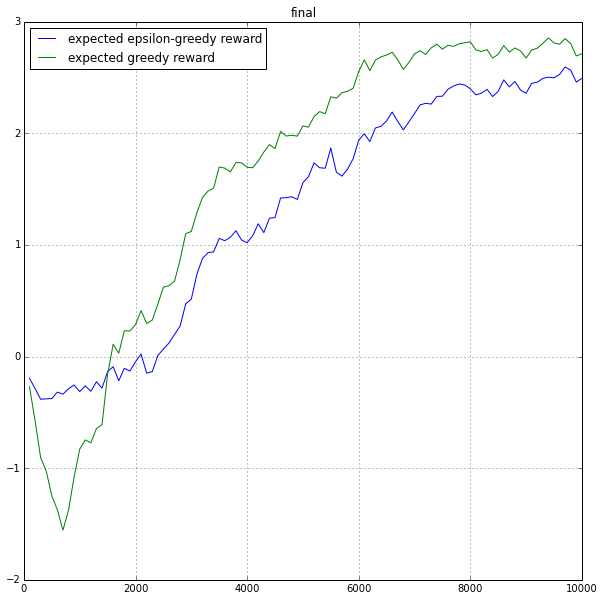

In [20]:
score_log.plot("final")

Random session examples
session # 0
 Y2(qv = 2.600437032) -> 3.0 |  X1(qv = 0.337158687579) -> 1.0 |  X3(qv = -0.0116605008581) -> 1.0 | 



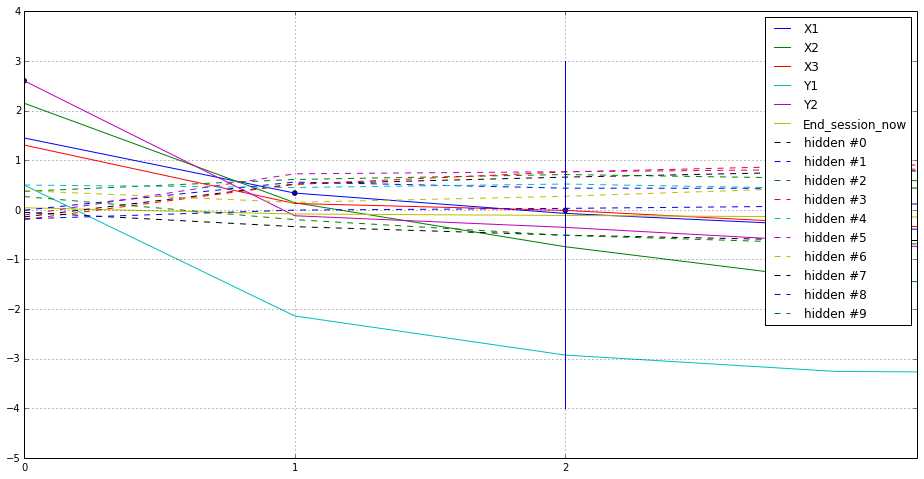

session # 1
 Y2(qv = 2.600437032) -> 3.0 |  X1(qv = 0.337158687579) -> 1.0 |  X3(qv = -0.0116605008581) -> 1.0 | 



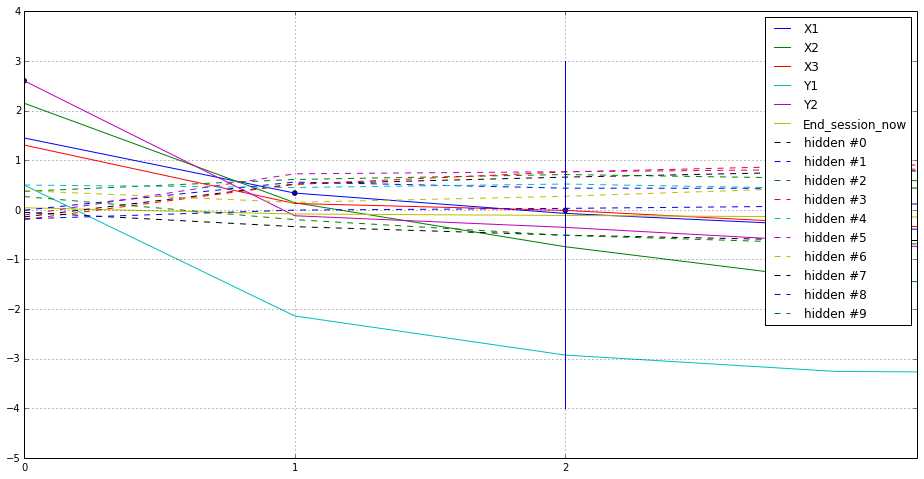

session # 2
 Y2(qv = 2.600437032) -> -3.0 |  X2(qv = 3.80423118085) -> 1.0 |  Y1(qv = 3.02515165212) -> 3.0 |  X3(qv = -0.00292832770056) -> -1.0 | 



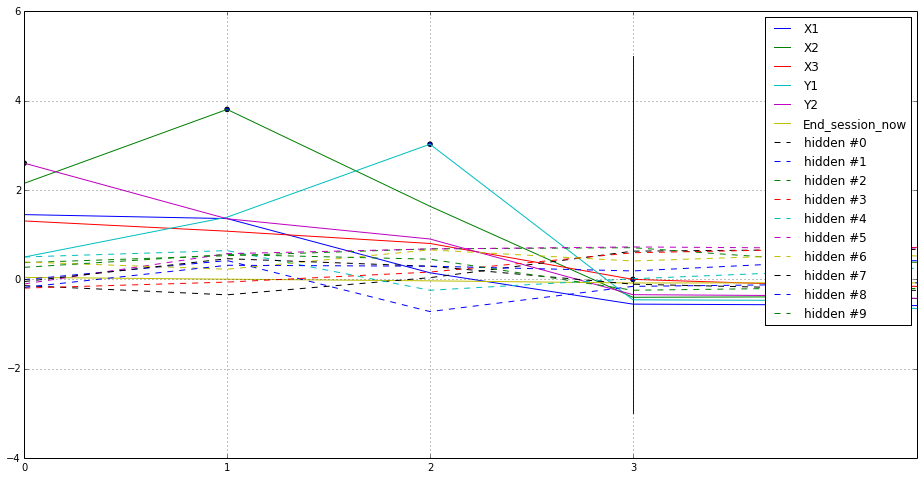

session # 3
 Y2(qv = 2.600437032) -> 3.0 |  X1(qv = 0.337158687579) -> 1.0 |  X3(qv = -0.0116605008581) -> 1.0 | 



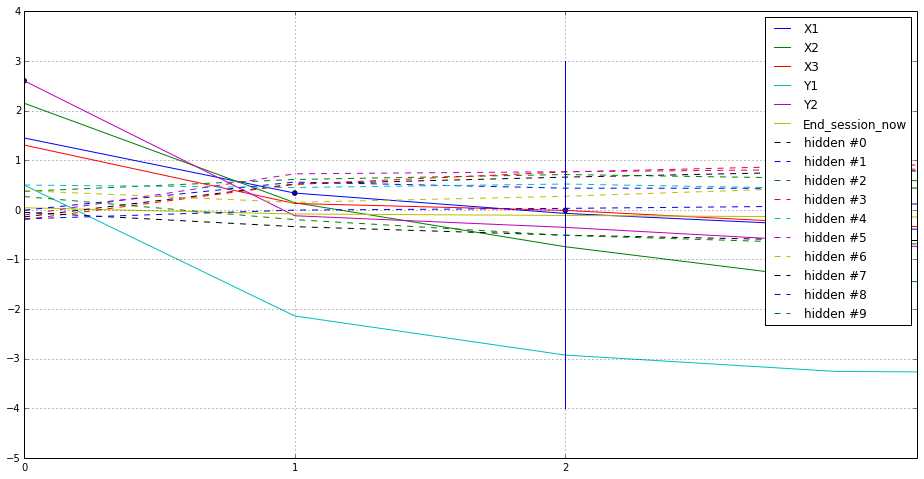

session # 4
 Y2(qv = 2.600437032) -> 3.0 |  X1(qv = 0.337158687579) -> 1.0 |  X3(qv = -0.0116605008581) -> 1.0 | 



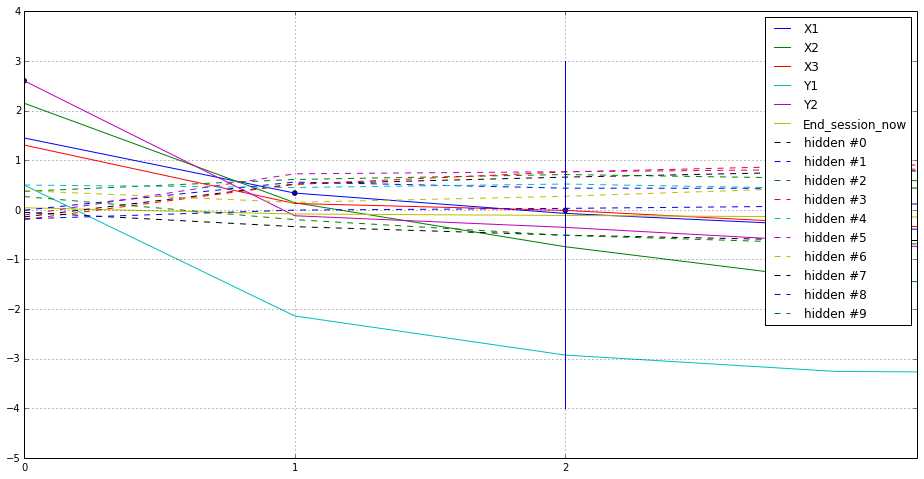

session # 5
 Y2(qv = 2.600437032) -> 3.0 |  X1(qv = 0.337158687579) -> -1.0 |  X3(qv = 0.00339473390418) -> 1.0 | 



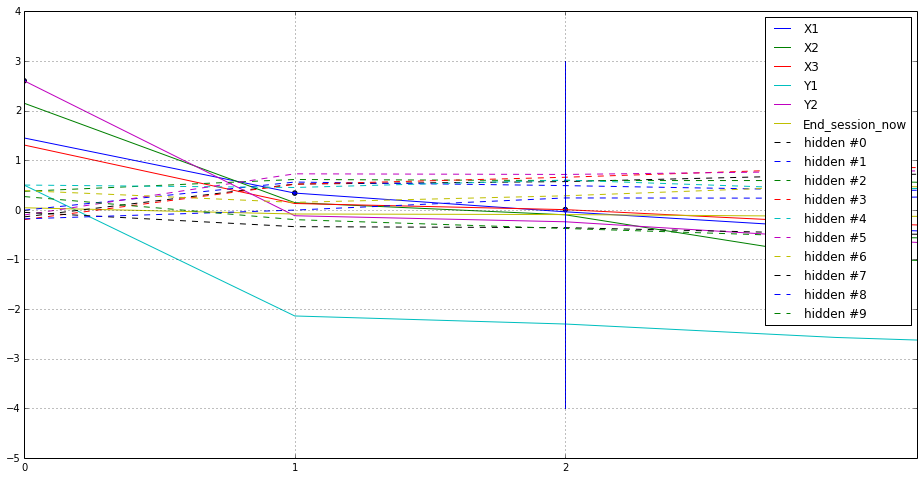

session # 6
 Y2(qv = 2.600437032) -> 3.0 |  X1(qv = 0.337158687579) -> 1.0 |  X3(qv = -0.0116605008581) -> -1.0 | 



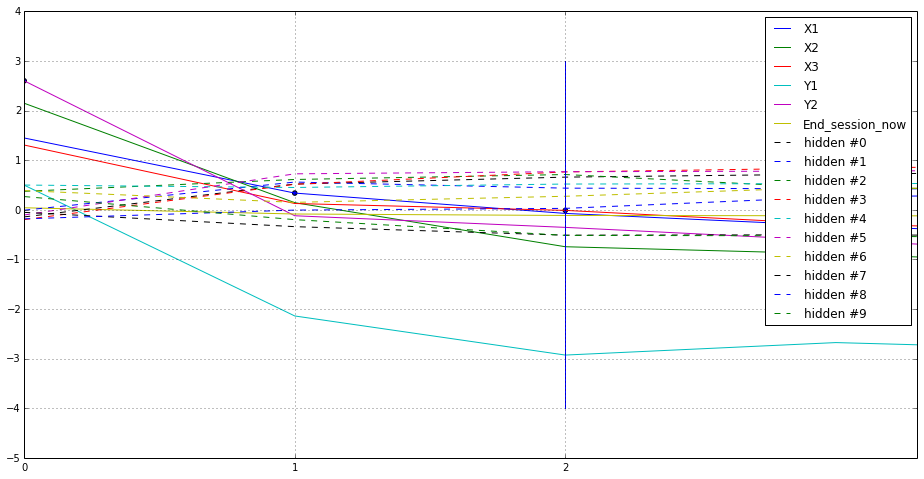

session # 7
 Y2(qv = 2.600437032) -> 3.0 |  X1(qv = 0.337158687579) -> -1.0 |  X3(qv = 0.00339473390418) -> 1.0 | 



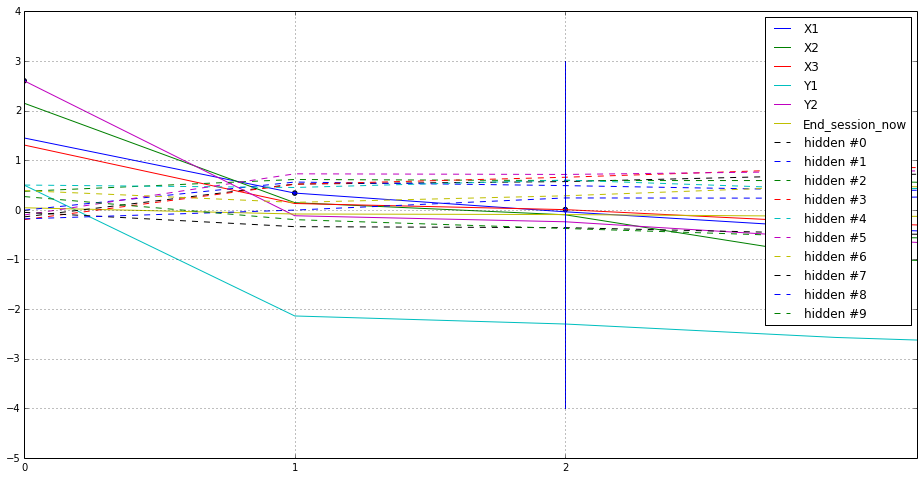

session # 8
 Y2(qv = 2.600437032) -> -3.0 |  X2(qv = 3.80423118085) -> 1.0 |  Y1(qv = 3.02515165212) -> 3.0 |  X3(qv = -0.00292832770056) -> 1.0 | 



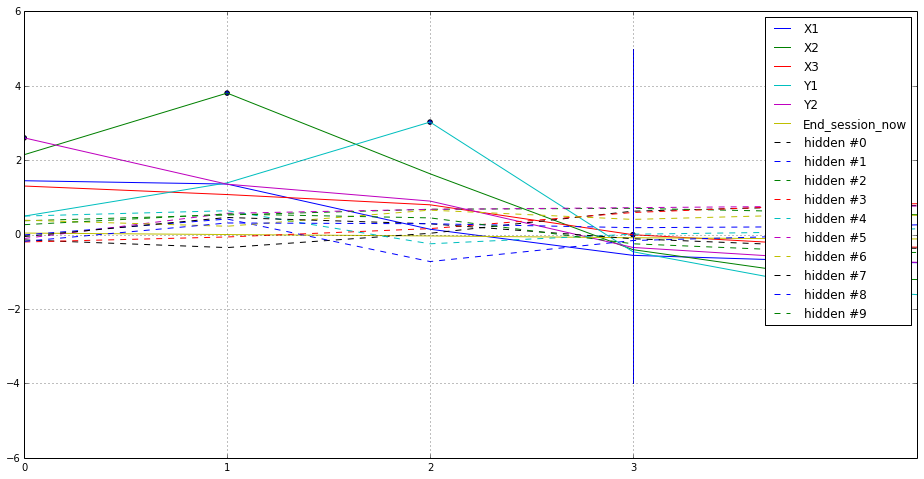

session # 9
 Y2(qv = 2.600437032) -> 3.0 |  X1(qv = 0.337158687579) -> 1.0 |  X3(qv = -0.0116605008581) -> 1.0 | 



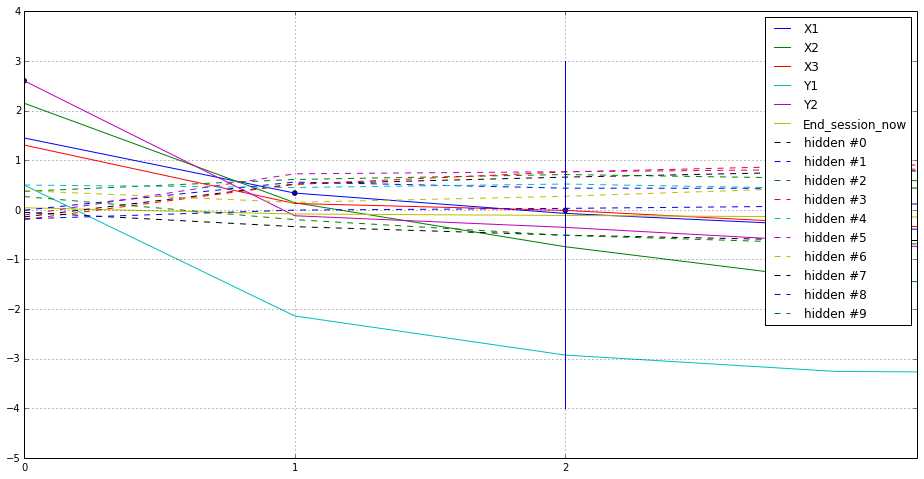

In [21]:
resolver.epsilon.set_value(np.float32(0.))
print "Random session examples"
env.generate_new_data_batch(10)
display_sessions(with_plots=True)
